In [1]:
# ----------------------------------------------------------
# COMP 542 – Machine Learning
# Class Number # 17086
# Group Project by: Jonathan Cordova and Phani Challabotla
# REGRESSION TREE MODEL for Stock Price Prediction
# ----------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

In [2]:
# get the s&p 500 index fund data
stock_data = yf.Ticker("^GSPC")

# get historical price data for s&p 500
df = pd.DataFrame(stock_data.history(period="max"))

# Print
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-30 00:00:00-04:00,5259.770020,5260.209961,5222.100098,5235.479980,3818750000,0.0,0.0
2024-05-31 00:00:00-04:00,5243.209961,5280.330078,5191.680176,5277.509766,5437160000,0.0,0.0
2024-06-03 00:00:00-04:00,5297.149902,5302.109863,5234.319824,5283.399902,4046920000,0.0,0.0


In [3]:
# Using info method to get a quick desc of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24223 entries, 1927-12-30 00:00:00-05:00 to 2024-06-05 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24223 non-null  float64
 1   High          24223 non-null  float64
 2   Low           24223 non-null  float64
 3   Close         24223 non-null  float64
 4   Volume        24223 non-null  int64  
 5   Dividends     24223 non-null  float64
 6   Stock Splits  24223 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5 MB


In [4]:
#
# --------------------------
# Preprocessing - Creating a custom functions for data cleaning:
# --------------------------
# 

def clean_dataset(df_series):

    # Calculating Momentum (Technical Indicator) and add new data column
    df_series['Momentum_Indicator'] = ta.MOM(df_series['Close'], timeperiod=2)

    # Calculating Money Flow Index (Technical Indicator) and add new data column
    df_series['Money_Flow_Index'] = ta.MFI(df_series['High'], df_series['Low'], df_series['Close'], df_series['Volume'], timeperiod=2)

    # Calculating Relative Strength Index (Technical Indicator) and add new data column
    df_series['Relative_Strength_Index'] = ta.RSI(df_series['Close'], timeperiod=2)

    # Calculating Rate of Change (Technical Indicator) and add new data column
    df_series['Rate_of_Change_Ratio'] = ta.ROCR(df_series['Close'], timeperiod=2)

    # Dropping all NaN rows
    df_series.dropna(subset=['Momentum_Indicator', 'Money_Flow_Index', 'Relative_Strength_Index', 'Rate_of_Change_Ratio'], inplace=True)

    # Drop columns Stock Splits and Dividends, axis = 1 represents type to drop 'column'
    df_series = df_series.drop(['Stock Splits', 'Dividends'], axis=1)

    # Format the Money Flow Index Indicator column and plot
    df_series['Money_Flow_Index'] = df_series['Money_Flow_Index'].round(6)
    
    # Add additional features including range (close - open) and daily mean ((high + low) / 2.0 )
    df_series['Daily_Range'] = (df_series['Close'] - df_series['Open'])
    df_series['Daily_Mean'] = (df_series['High'] + df_series['Low']) / 2.0

    # Turns Date index into a feature (column)
    df_series = df_series.reset_index()

    # Filter data between two dates to reflect data from 10-01-1990 through 10-01-2022
    filtered_df_series = df_series.loc[(df_series['Date'] >= '1990-10-01')
                         & (df_series['Date'] <= '2022-10-01')]

    # Resets the row index to 0
    filtered_df_series = filtered_df_series.reset_index(drop=True)

    # Makes the Date column back into an index 
    filtered_df_series = filtered_df_series.set_index('Date')
    df_series = filtered_df_series
    
    # Drop column 'Rate_of_Change_Ratio' due to high correlation with 'Momentum_Indicator', axis = 1 represents type column
    df_series = df_series.drop(['Rate_of_Change_Ratio'], axis=1)

    return df_series


# Cleaning all datasets for the S&P 500 using custom function
df = clean_dataset(df)

In [5]:
# Information for numerical attributes (features)
df.describe()

,Open,High,Low,Close,Volume,Momentum_Indicator,Money_Flow_Index,Relative_Strength_Index,Daily_Range,Daily_Mean
count,8063.000000,8063.000000,8063.000000,8063.000000,8.063000e+03,8063.000000,8063.000000,8063.000000,8063.000000,8063.000000
mean,1511.357602,1520.300416,1501.698549,1511.606558,2.450039e+09,0.820919,54.068904,55.379125,0.248956,1510.999483
std,975.513523,980.647994,969.712286,975.446771,1.838858e+09,27.792306,38.193554,31.081190,17.455088,975.149794
min,295.450012,301.450012,294.510010,295.459991,1.499000e+07,-401.590088,-0.000000,0.071289,-150.220215,297.980011
25%,909.600006,918.804993,898.915009,909.705017,6.815000e+08,-7.500000,0.000000,26.307692,-5.000000,908.837494
50%,1260.819946,1268.189941,1253.030029,1260.680054,2.403470e+09,1.299927,50.741857,59.693967,0.540009,1260.625000
75%,1949.119995,1961.429993,1937.534973,1950.385010,3.796280e+09,11.154984,100.000000,83.846606,6.685059,1948.565002
max,4804.509766,4818.620117,4780.040039,4796.560059,1.145623e+10,238.160156,100.000000,99.995138,141.030029,4796.445068


In [6]:
df.head()

,Open,High,Low,Close,Volume,Momentum_Indicator,Money_Flow_Index,Relative_Strength_Index,Daily_Range,Daily_Mean
Date,,,,,,,,,,
1990-10-01 00:00:00-04:00,306.100006,314.940002,306.100006,314.940002,202210000,13.970001,100.000000,87.375022,8.839996,310.520004
1990-10-02 00:00:00-04:00,314.940002,319.690002,314.940002,315.209991,188360000,9.160004,100.000000,87.865920,0.269989,317.315002
1990-10-03 00:00:00-04:00,315.209991,316.260010,310.700012,311.399994,135490000,-3.540009,58.458327,41.892570,-3.809998,313.480011
1990-10-04 00:00:00-04:00,311.399994,313.399994,308.589996,312.690002,145410000,-2.519989,0.000000,57.094444,1.290009,310.994995
1990-10-05 00:00:00-04:00,312.690002,314.790009,305.760010,311.500000,153380000,0.100006,0.000000,38.507845,-1.190002,310.275009


In [7]:
df.tail()

,Open,High,Low,Close,Volume,Momentum_Indicator,Money_Flow_Index,Relative_Strength_Index,Daily_Range,Daily_Mean
Date,,,,,,,,,,
2022-09-26 00:00:00-04:00,3682.719971,3715.669922,3644.760010,3655.040039,4886140000,-102.949951,-0.000000,1.057540,-27.679932,3680.214966
2022-09-27 00:00:00-04:00,3686.439941,3717.530029,3623.290039,3647.290039,4577740000,-45.939941,-0.000000,0.904572,-39.149902,3670.410034
2022-09-28 00:00:00-04:00,3651.939941,3736.739990,3640.610107,3719.040039,4684850000,64.000000,50.823289,73.059277,67.100098,3688.675049
2022-09-29 00:00:00-04:00,3687.010010,3687.010010,3610.399902,3640.469971,4681810000,-6.820068,50.375917,28.157228,-46.540039,3648.704956
2022-09-30 00:00:00-04:00,3633.479980,3671.439941,3584.129883,3585.620117,5645360000,-133.419922,-0.000000,15.153755,-47.859863,3627.784912


In [8]:
# Show the count of tuples (rows) for S&P500 data set

print("S&P 500 Tuples (Rows) count: ", len(df.index))

S&P 500 Tuples (Rows) count:  8063


C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


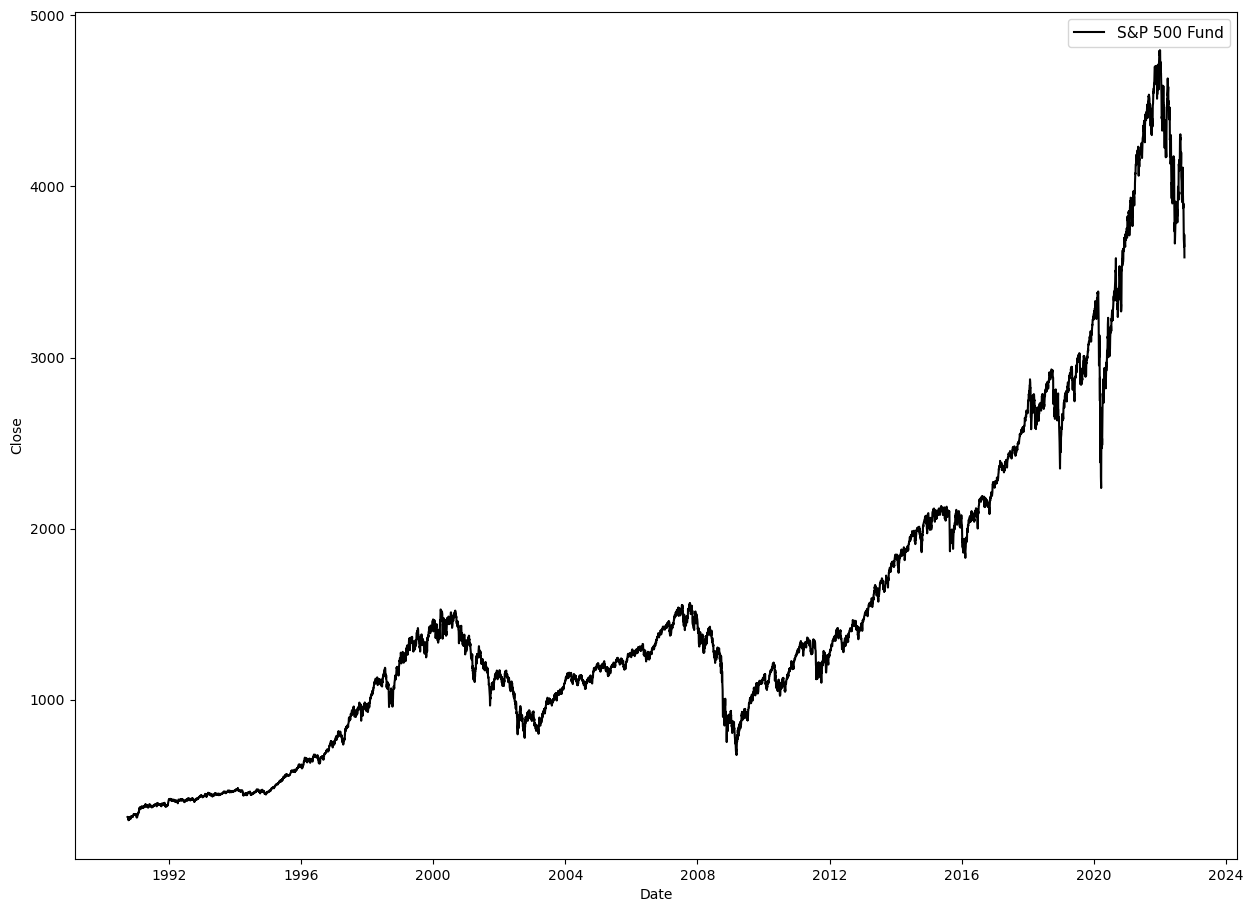

In [9]:
plt.figure(figsize=(15,11))
    
sns.lineplot(x = "Date", y = "Close", 
             color = 'black', data = df)

plt.legend(['S&P 500 Fund'], prop={'size': 11})
plt.show()

In [10]:
# ---------------------------------------------------------------------------------------------------
# Train the stocks data sets individually using S&P 500
# ---------------------------------------------------------------------------------------------------

# Make new variable for S&P 500 only
df_sp500 = df

# Print tuples (row) count
print("df_sp500 Tuples (Rows) count: ", len(df_sp500.index))

# Sort by Date column
df_sp500 = df_sp500.sort_values(by=['Date'])

# Turns Date index into a feature (column)
df_sp500 = df_sp500.reset_index()

# Get training and testing set
training_set = df_sp500.loc[df_sp500['Date'] <= '2022-04-01']
testing_set = df_sp500.loc[df_sp500['Date'] >= '2022-04-01']

# Resets the row index to 0
df_sp500 = df_sp500.reset_index(drop=True)
training_set = training_set.reset_index(drop=True)
testing_set = testing_set.reset_index(drop=True)

# Makes the Date column back into an index 
df_sp500 = df_sp500.set_index('Date')
training_set = training_set.set_index('Date')
testing_set = testing_set.set_index('Date')

# Training Set
X_train_sp500 = training_set.drop(labels=['Close'], axis=1)
y_train_sp500 = training_set['Close']

# Testing Set
X_test_sp500 = testing_set.drop(labels=['Close'], axis=1)
y_test_sp500 = testing_set['Close']


df_sp500 Tuples (Rows) count:  8063


C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as

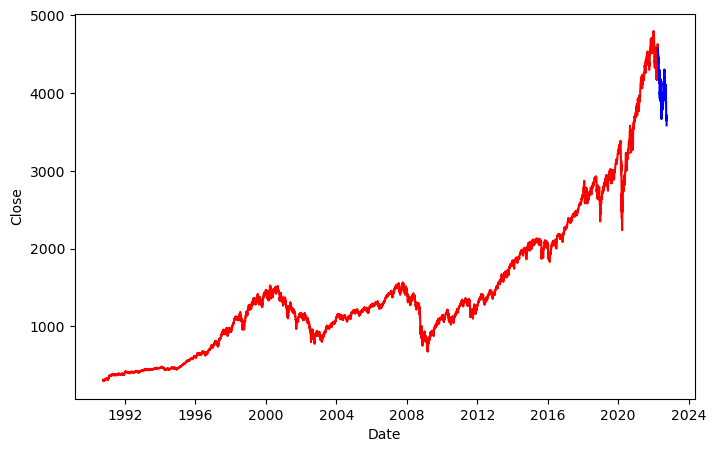

In [11]:
# Visualizing that the training set were split correctly on a lineplot

# INDIVIDUAL stock S&P 500
plt.figure(figsize=(8,5))
sns.lineplot( x = "Date", y = "Close", 
                     color = 'r', data = training_set)
sns.lineplot( x = "Date", y = "Close", 
                     color = 'b', data = testing_set)

plt.show()

In [12]:
# Standard Scaler
# Scaling the data with Standard Scaler

scaler = StandardScaler().fit(X_train_sp500)
scaled_X_train_sp500 = scaler.transform(X_train_sp500)


In [13]:
# -----------------------------------
# Regression Tree - Training
# -----------------------------------

regression_tree = DecisionTreeRegressor(criterion='squared_error', min_samples_leaf=1, random_state=42, min_impurity_decrease = 0.0)

regression_tree.fit(scaled_X_train_sp500, y_train_sp500)


DecisionTreeRegressor(random_state=42)

In [14]:
#-----------------------------------------------------------------
# Regression Tree on Test Data
#-----------------------------------------------------------------

scaled_X_test_sp500 = scaler.transform(X_test_sp500)
y_pred_sp500 = regression_tree.predict(scaled_X_test_sp500)

In [15]:
y_pred_sp500

array([4545.85986328, 4591.66992188, 4535.43017578, 4500.52978516,
       4521.54003906, 4496.18994141, 4432.99023438, 4400.27001953,
       4438.25976562, 4400.27001953, 4400.64013672, 4438.25976562,
       4473.75      , 4380.25976562, 4357.72998047, 4262.45019531,
       4204.31005859, 4221.85986328, 4262.45019531, 4173.10986328,
       4115.68017578, 4180.16992188, 4262.45019531, 4173.10986328,
       4063.04003906, 4019.87011719, 4019.87011719, 4019.87011719,
       3889.13989258, 3972.88989258, 4019.87011719, 4077.90991211,
       4019.87011719, 3889.13989258, 3821.35009766, 3931.33007812,
       3889.13989258, 3974.12011719, 4019.87011719, 4077.90991211,
       4134.93994141, 4079.94995117, 4077.90991211, 4124.66015625,
       4134.93994141, 4077.90991211, 4134.93994141, 4063.04003906,
       3915.45996094, 3750.77001953, 3748.13989258, 3773.86010742,
       3672.82006836, 3694.91992188, 3748.13989258, 3773.86010742,
       3773.86010742, 3881.37011719, 3898.81005859, 3889.13989

In [16]:
y_test_sp500

Date
2022-04-01 00:00:00-04:00    4545.859863
2022-04-04 00:00:00-04:00    4582.640137
2022-04-05 00:00:00-04:00    4525.120117
2022-04-06 00:00:00-04:00    4481.149902
2022-04-07 00:00:00-04:00    4500.209961
                                ...     
2022-09-26 00:00:00-04:00    3655.040039
2022-09-27 00:00:00-04:00    3647.290039
2022-09-28 00:00:00-04:00    3719.040039
2022-09-29 00:00:00-04:00    3640.469971
2022-09-30 00:00:00-04:00    3585.620117
Name: Close, Length: 126, dtype: float64

In [17]:
# Evaluation

print("Testing Set - Mean Squared Error is: ", mean_squared_error(y_pred_sp500, y_test_sp500, squared=True))
print("Testing Set - Root Mean Squared Error is: ", mean_squared_error(y_pred_sp500, y_test_sp500, squared=False))
print("Testing Set - Mean Absolute Error is: ", mean_absolute_error(y_pred_sp500, y_test_sp500))

# This measures the variation in the dependent variable that is predictable from the independent variable
print("Testing Set - R2 Score is: ", r2_score(y_pred_sp500, y_test_sp500))

Testing Set - Mean Squared Error is:  1378.5854843386583
Testing Set - Root Mean Squared Error is:  37.129307619973986
Testing Set - Mean Absolute Error is:  27.922787620907737
Testing Set - R2 Score is:  0.9728670845441455


C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


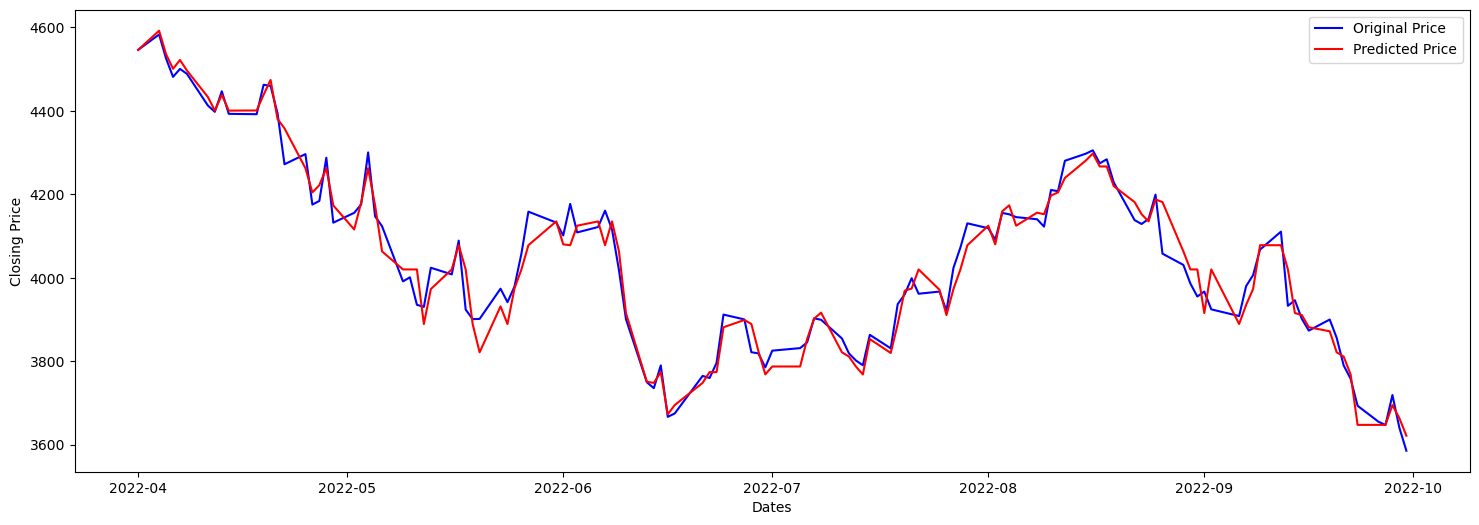

In [18]:
# Turning the Predicted data from an array into a data frame for plotting purposes

# Grabbing the 'Date' index from test set
Date_index = X_test_sp500.index

df_y_pred_sp500 = pd.DataFrame()
df_y_pred_sp500['Close'] = y_pred_sp500
df_y_pred_sp500['Date'] = Date_index
y_pred_sp500 = df_y_pred_sp500.set_index('Date')


# Plotting our results
plt.figure(figsize=(18, 6))
plt.plot(y_test_sp500, 'b', label = 'Original Price')
plt.plot(y_pred_sp500, 'r', label = 'Predicted Price')
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [19]:
# Extra Regression Tree - Training Set
# -----------------------
extra_regression_tree = ExtraTreesRegressor(n_estimators=100, random_state=42)

extra_regression_tree.fit(scaled_X_train_sp500, y_train_sp500)

ExtraTreesRegressor(random_state=42)

In [20]:
# Extra Regression Tree - Test Set
# -----------------------
y_pred_sp500 = extra_regression_tree.predict(scaled_X_test_sp500)

In [21]:
# Evaluation of Extra Regression Tree

print("Testing Set - Mean Squared Error is: ", mean_squared_error(y_pred_sp500, y_test_sp500, squared=True))
print("Testing Set - Root Mean Squared Error is: ", mean_squared_error(y_pred_sp500, y_test_sp500, squared=False))
print("Testing Set - Mean Absolute Error is: ", mean_absolute_error(y_pred_sp500, y_test_sp500))

# This measures the variation in the dependent variable that is predictable from the independent variable
print("Testing Set - R2 Score is: ", r2_score(y_pred_sp500, y_test_sp500))

Testing Set - Mean Squared Error is:  531.1067262367926
Testing Set - Root Mean Squared Error is:  23.04575288934585
Testing Set - Mean Absolute Error is:  17.95094042581224
Testing Set - R2 Score is:  0.9892016421473158


C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


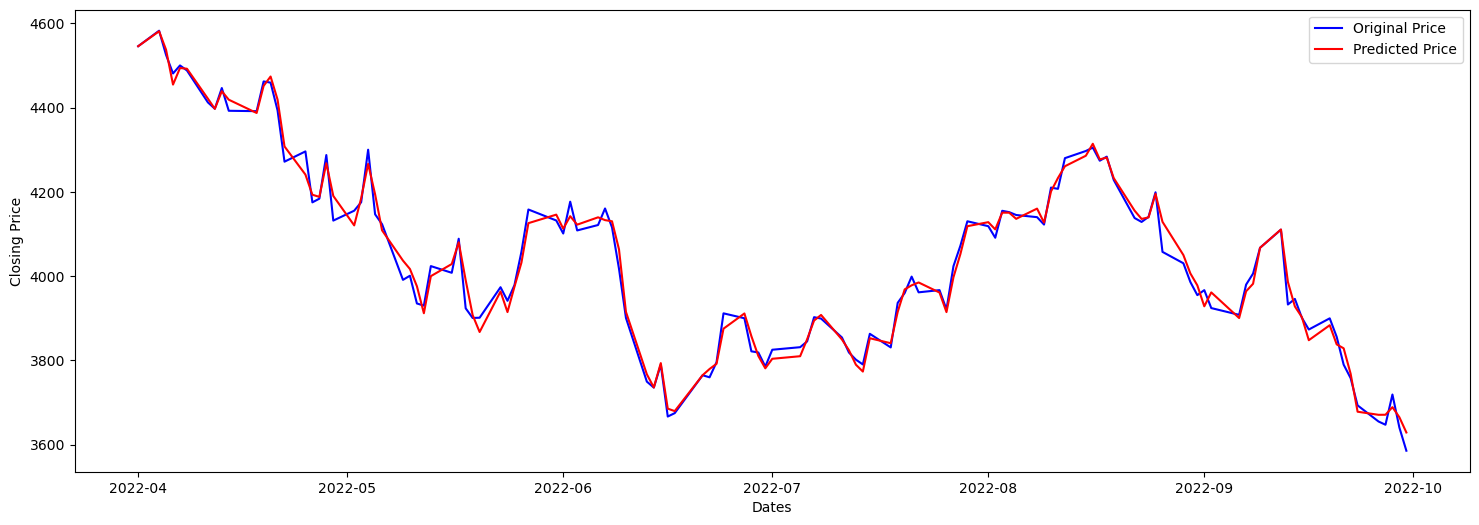

In [22]:
# Turning the Predicted data from an array into a data frame for plotting purposes for of Extra Regression Tree

# Grabbing the 'Date' index from test set
Date_index = X_test_sp500.index

df_y_pred_sp500 = pd.DataFrame()
df_y_pred_sp500['Close'] = y_pred_sp500
df_y_pred_sp500['Date'] = Date_index
y_pred_sp500 = df_y_pred_sp500.set_index('Date')


# Plotting our results
plt.figure(figsize=(18, 6))
plt.plot(y_test_sp500, 'b', label = 'Original Price')
plt.plot(y_pred_sp500, 'r', label = 'Predicted Price')
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [23]:
# Regression Forest - Training Set
# -----------------------
regression_forest = RandomForestRegressor(random_state=42)

regression_forest.fit(scaled_X_train_sp500, y_train_sp500)

RandomForestRegressor(random_state=42)

In [24]:
# Regression Forest - Test Set
# -----------------------
y_pred_sp500 = regression_forest.predict(scaled_X_test_sp500)

In [25]:
# Evaluation of Regression Forest

print("Testing Set - Mean Squared Error is: ", mean_squared_error(y_pred_sp500, y_test_sp500, squared=True))
print("Testing Set - Root Mean Squared Error is: ", mean_squared_error(y_pred_sp500, y_test_sp500, squared=False))
print("Testing Set - Mean Absolute Error is: ", mean_absolute_error(y_pred_sp500, y_test_sp500))

# This measures the variation in the dependent variable that is predictable from the independent variable
print("Testing Set - R2 Score is: ", r2_score(y_pred_sp500, y_test_sp500))

Testing Set - Mean Squared Error is:  711.0829534232636
Testing Set - Root Mean Squared Error is:  26.66613870479308
Testing Set - Mean Absolute Error is:  21.14553999643478
Testing Set - R2 Score is:  0.9855486423542215


C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\cordo\anaconda3\envs\machine_learning_base\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


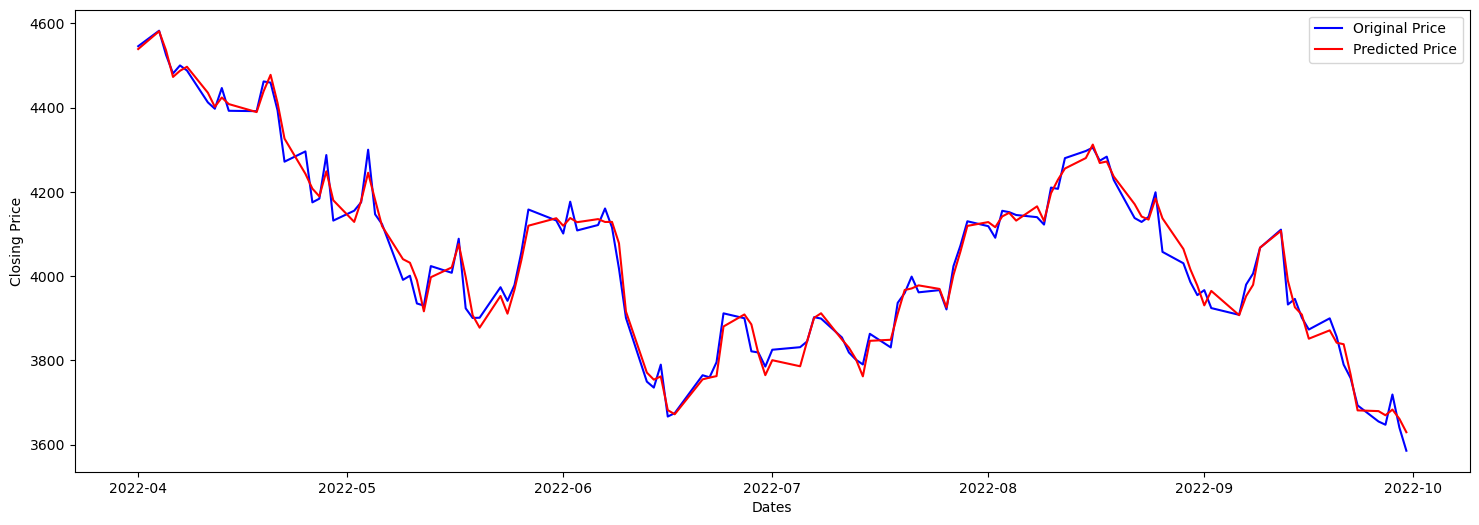

In [26]:
# Turning the Predicted data from an array into a data frame for plotting purposes for of Regression Forest

# Grabbing the 'Date' index from test set
Date_index = X_test_sp500.index

df_y_pred_sp500 = pd.DataFrame()
df_y_pred_sp500['Close'] = y_pred_sp500
df_y_pred_sp500['Date'] = Date_index
y_pred_sp500 = df_y_pred_sp500.set_index('Date')


# Plotting our results
plt.figure(figsize=(18, 6))
plt.plot(y_test_sp500, 'b', label = 'Original Price')
plt.plot(y_pred_sp500, 'r', label = 'Predicted Price')
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.legend()
plt.show()